# Finding bboxes from labeled points

In [83]:
%matplotlib inline
from laspy.file import File
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

In [84]:
lidar_inFile = File("tram/Tram_rtc360_subsampled_classified.las", mode = "r")

In [85]:
# Find out what the point format looks like.
pointformat = lidar_inFile.point_format
for spec in lidar_inFile.point_format:
    print(spec.name)

X
Y
Z
intensity
flag_byte
raw_classification
scan_angle_rank
user_data
pt_src_id
gps_time
red
green
blue


In [86]:
all(lidar_inFile.raw_classification == lidar_inFile.classification)

True

### Notice 0 is the background points

In [87]:
# count each class
from collections import Counter

print('total points', len(lidar_inFile.points))
print(Counter(lidar_inFile.classification).keys()) # equals to list(set(words))
print(Counter(lidar_inFile.classification).values()) # counts the elements' frequency

total points 16629808
dict_keys([0, 3, 4, 2, 8, 5, 7, 6, 9])
dict_values([16292835, 151910, 30518, 53664, 10361, 13747, 56614, 1843, 18316])


In [88]:
from sklearn.preprocessing import StandardScaler

### **It is vital to normalize the point coordinate !**
since the rounding error will cause even simple sanity checks like points of an instance being in it's box to fail 

In [89]:
points = np.vstack((lidar_inFile.x, lidar_inFile.y, lidar_inFile.z, lidar_inFile.red, lidar_inFile.green, lidar_inFile.blue, lidar_inFile.classification )).transpose()
# normalize the x,y,z of points to reduce calculation error
points[:,0:3] = StandardScaler().fit_transform(points[:,0:3])

## Lets use DBSCAN to cluster the pipes in each class into separate pipes

In [90]:
# choose class 1
class_num = 1
mask = lidar_inFile.classification == class_num
class1 = points[mask]
class1 = class1[:,0:3]

In [91]:
# save to file then use vscode to run the interactive plot
np.savez('point_cloud',xyz=class1)

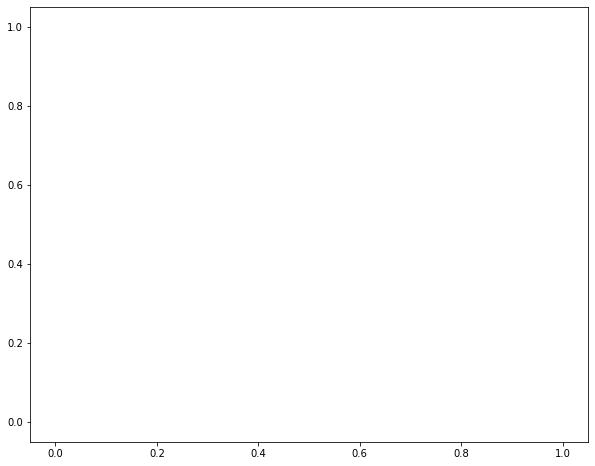

In [92]:
#color = subsample[:,3:] / 65535

plt.figure(figsize=(10, 8)) # #dpi=80)

plt.scatter(class1[:,0], class1[:,1], marker='.', s=0.01)

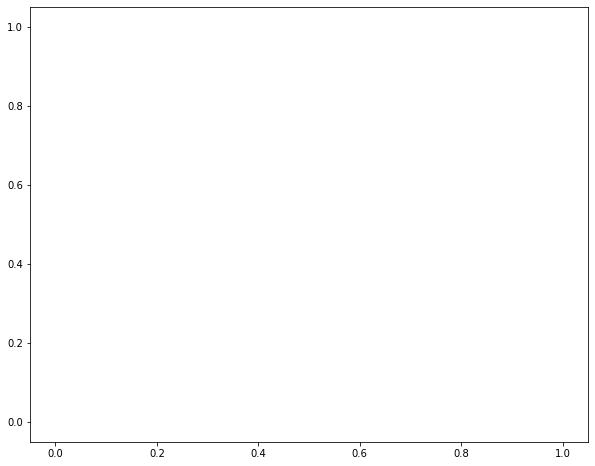

In [93]:
plt.figure(figsize=(10, 8)) # #dpi=80)

plt.scatter(class1[:,0], class1[:,2], marker='.', s=0.01)

**now we see esi = 0.05 is good since the pipes are close together have a distance as close as 0.1**
**eventually lets' experiment**


below code from : https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

In [94]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [95]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.05, min_samples=10).fit(class1)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# determin core sampels
core_samples_mask[db.core_sample_indices_] = True
# given class label by the algo
labels = db.labels_

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [96]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 1
Estimated number of noise points: 0


In [97]:
# plot result
# Black removed and is used for noise instead.
plt.figure(figsize=(10, 8))

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xyz = class1[class_member_mask & core_samples_mask]
    plt.scatter(xyz[:, 0], xyz[:, 1], marker='.', color=tuple(col),
              s=0.5)

    xyz = class1[class_member_mask & ~core_samples_mask]
    plt.scatter(xyz[:, 0], xyz[:, 1], marker='.', color=tuple(col),
              s=1)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

print('number of outliers %d'%len(labels[labels==-1]))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 13502

<Figure size 720x576 with 0 Axes>

**note when the eps value is too low and you have too many clusters (like 60) then the visualization doesn't work correctly since the classes will get very similar colors that are indistinguishable.**

## Now get the bboxes

<s>e.g pyformex bbox() see: http://www.nongnu.org/pyformex/doc-0.9/ref/coords.html
see what happens to results (doesn't look very reliable)</s> (the bbox here is just the min/max solution)

also see : https://gis.stackexchange.com/questions/22895/finding-minimum-area-rectangle-for-given-points it seems extending the algorithm to 3 dimensions is harder. (also see the O'Rourke algo here : https://en.wikipedia.org/wiki/Minimum_bounding_box_algorithms#cite_note-3)

for now I will use PCA to find the box.

In [98]:
# filter down to 1 instance according to unique_labels 
# remove the points labeled -1 (-1 are outliers)
obj_labels = list(unique_labels - set([-1]))
obj_labels

[0]

In [99]:
a = np.array([[1,2],[1,2]])

a - np.mean(a,axis=0)

array([[0., 0.],
       [0., 0.]])

In [100]:
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition


def find_bboxes(xyz):
    '''finds and returns the 8 corners of the bbox of the given point cloud 
    using PCA
    
    Args:
        xyz (n*3 array): The first parameter.
        param2 (str): The second parameter.

    Returns:
        corners (8*3 array): the returned array is the 8 corners of the bounding box
    '''
    # find the bbox of points in xyz
    # using PCA
    
    # first center the instance in the origin (NO MULTIPLICATIVE SCALING !)
    means = np.mean(xyz,axis=0)
    centered_xyz = xyz - means
    
    pca = decomposition.PCA(n_components=3)
    pca.fit(centered_xyz)
    # we don't need to get the pca components since we have the functions to do the transformations for us !
    transed_xyz = pca.transform(centered_xyz)

    # find the min/max of x,y,z in the new coordinate
    mins = np.min(transed_xyz,axis=0)
    maxs = np.max(transed_xyz,axis=0)

    # get the corners it is just the cartesian product (like a truth table) of the mins and maxs
    pca_corners = list(itertools.product([mins[0],maxs[0]], [mins[1],maxs[1]], [mins[2],maxs[2]]))

    # transform back to the original coordinate
    # notice PCA is just a rotation transformation so it preserves the distances of points
    corners = pca.inverse_transform(pca_corners) 
    
    #add the means back
    corners = corners + means
    
    return corners

In [101]:
obj_labels

[0]

In [102]:
print(Counter(labels).keys()) # equals to list(set(words))
print(Counter(labels).values()) # counts the elements' frequency

dict_keys([0])
dict_values([13502])


In [103]:
# one row per pipe each one has 8 corners for bbox
corners = np.zeros((len(obj_labels), 8, 3))

for obj_idx in obj_labels:
    # filter down to 1 instance
    object_member_mask = (labels == obj_idx)
    xyz = class1[object_member_mask]

    # find the bbox of points in xyz
    # using PCA
    corners[obj_idx] = find_bboxes(xyz)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 13502

For an interactive plot use matlplotlib3d in vscode(commandline) !
save 1 pipe at a time.

In [104]:
# choose 1 instance
obj_idx = 1
object_member_mask = (labels == obj_idx)
xyz = class1[object_member_mask]
np.savez('point_cloud', xyz=xyz , corners=corners[obj_idx] )

IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 13502

#### We do some sanity checks below: is the box orthogonal and are all points inside the box

In [105]:
def check_orthogonal(a,b,c):
    '''check if three input vectors are orthogonal 
    notice abs less than 10^-10 is assumed zero'''
    cond1 = np.abs(np.inner(a,b))
    cond2 = np.abs(np.inner(a,c))
    cond3 = np.abs(np.inner(b,c))
    
    #print(a,b,c)
    #print()
    #print(cond1, cond2, cond3)
    #input('wait')
    
    is_ortho = True if (cond1<1e-9 and cond2<1e-9 and cond3<1e-9) else False
    
    return is_ortho

def check_corner(corners,base, n1, n2, n3):
    '''check if the corner is all orthogonal
    the corner of interest base and 3 neighbours
    corner is the corners array'''
    return check_orthogonal(corners[base]-corners[n1], corners[base]-corners[n2], corners[base]-corners[n3])
    
def is_box(corners):
    '''get an array of corners for multiple objects cheks for each object
    if it has an orthogonal'''
    adjacancy =  [
    [0, 1,2,4],
    [1, 0,3,5],
    [2, 0,6,3],
    [3, 2,7,1],
    [4, 0,5,6],
    [5, 1,4,7],
    [6, 2,4,7],
    [7, 3,5,6]
    ] 
    # check all bboxes for all objects are actually boxes
    correct = True

    for i, c in enumerate(corners):
        for adj in adjacancy:
            if not check_corner(c,*adj):
                print('corners:', i)
                print(adj)
                correct = False

    return correct

In [106]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    from scipy.spatial import Delaunay
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return all(hull.find_simplex(p)>=0)

def all_points_in_box(points, corners, labels, obj_labels):
    '''are all points in their own boxes'''
    correct = True
    
    for obj_idx in obj_labels:
        # filter down to 1 instance
        object_member_mask = (labels == obj_idx)
        xyz = points[object_member_mask]
        
        if not in_hull(xyz, corners[obj_idx]):
            print(obj_idx)
            correct = False
    return correct

In [107]:
# check box is orthogonal (sanity check)
# all the points have the same outline of corner points
# edges as vectors

# put base and neighbours in an array

# this is for 1 class
print(is_box(corners))

print(all_points_in_box(class1, corners, labels, obj_labels))

True


IndexError: boolean index did not match indexed array along dimension 0; dimension is 0 but corresponding boolean dimension is 13502

## Save the bbox corners and instances found in files

I will save the points data in a np file along with the extra column for the instance number we found (obj_labels)

I will put the whole process in a loop for each class to automate this.

////////////////////////////
 analyzing class: 2


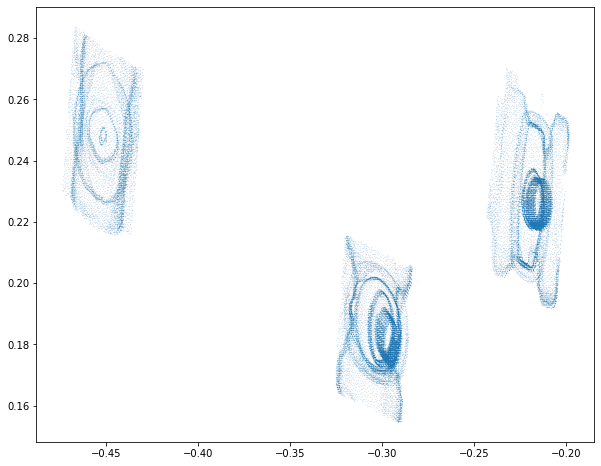

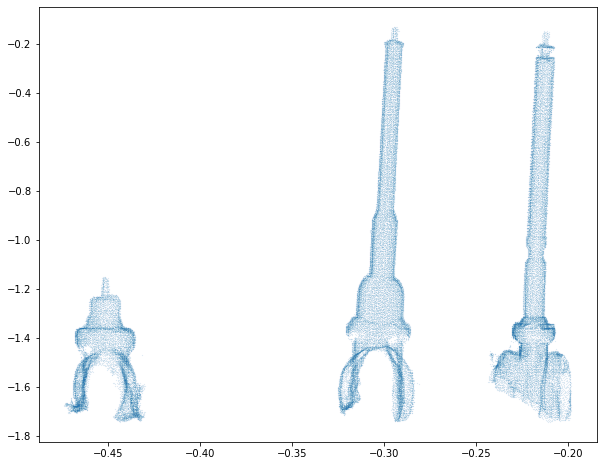

Estimated number of clusters: 2
Estimated number of noise points: 0


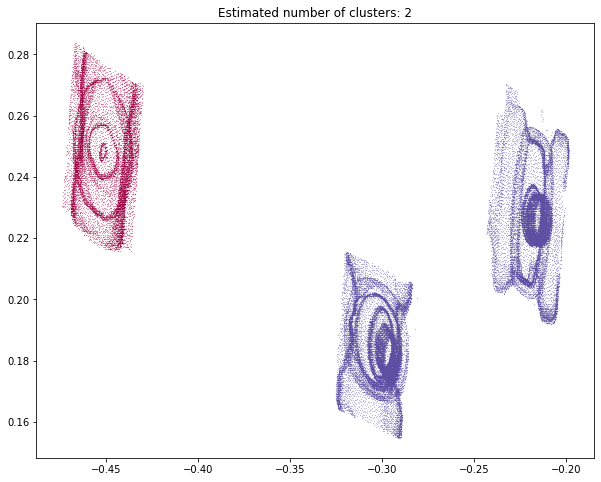

number of outliers 0


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.100000)? 0.05
give number of min sampels: 10


Estimated number of clusters: 2
Estimated number of noise points: 0


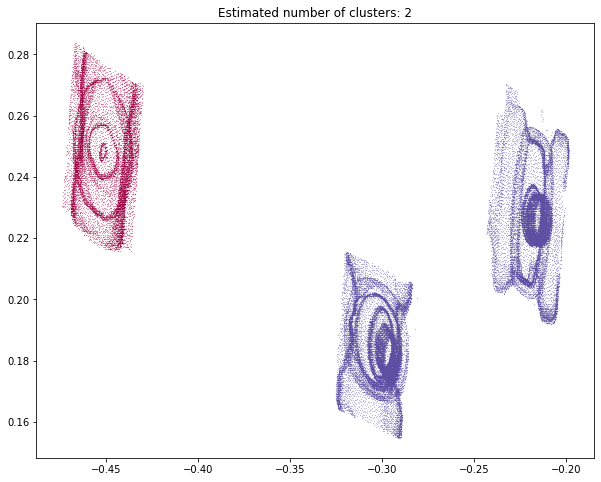

number of outliers 0


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.050000)? 0.02
give number of min sampels: 10


Estimated number of clusters: 3
Estimated number of noise points: 0


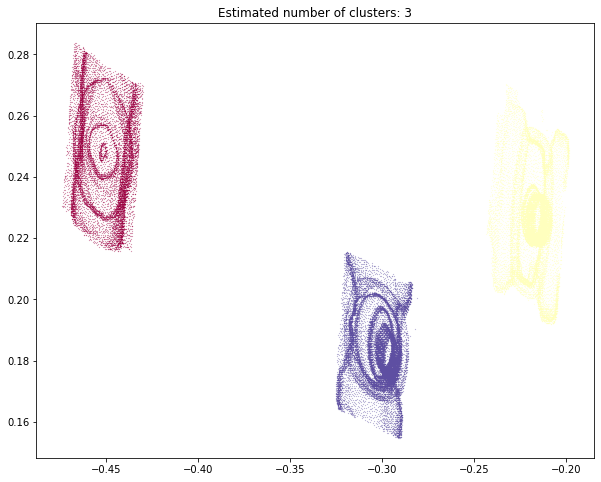

number of outliers 0


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 3


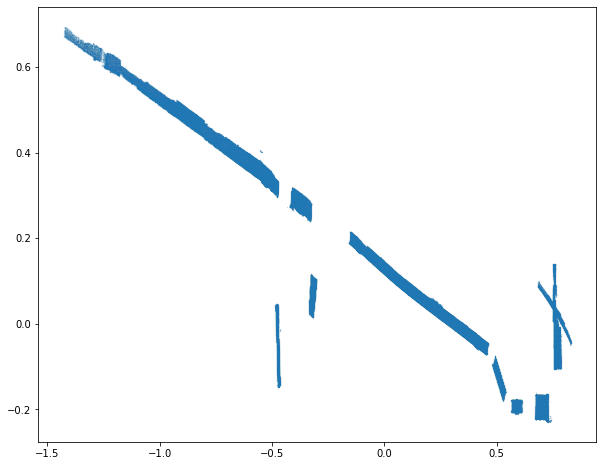

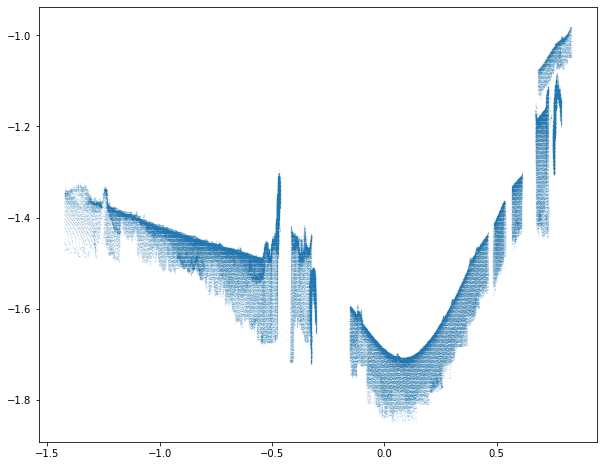

Estimated number of clusters: 10
Estimated number of noise points: 1


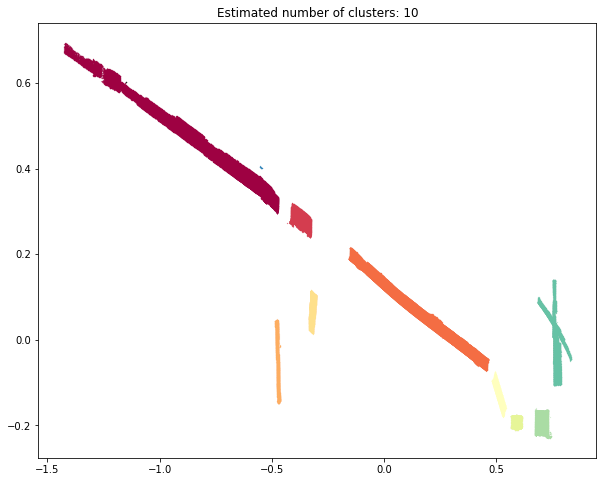

number of outliers 1


save and wait for plot 3D ? y
waiting to continue: 
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? 0.1
give number of min sampels: 10


Estimated number of clusters: 4
Estimated number of noise points: 0


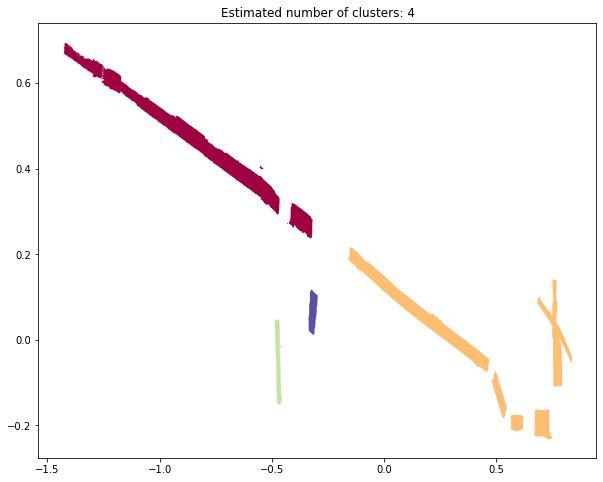

number of outliers 0


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.100000)? 0.02
give number of min sampels: 50


Estimated number of clusters: 9
Estimated number of noise points: 97


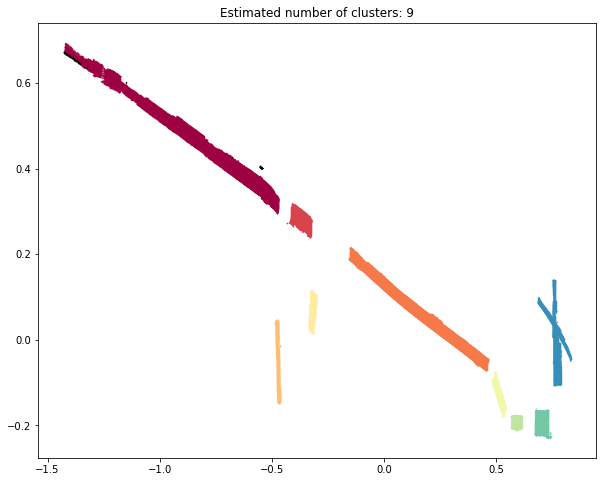

number of outliers 97


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? 0.02
give number of min sampels: 30


Estimated number of clusters: 9
Estimated number of noise points: 30


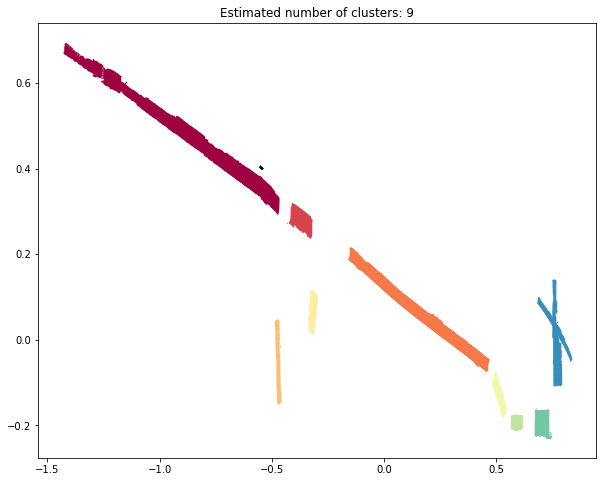

number of outliers 30


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 4


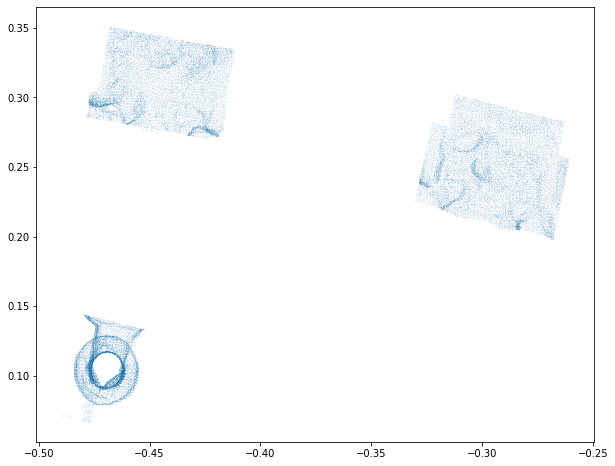

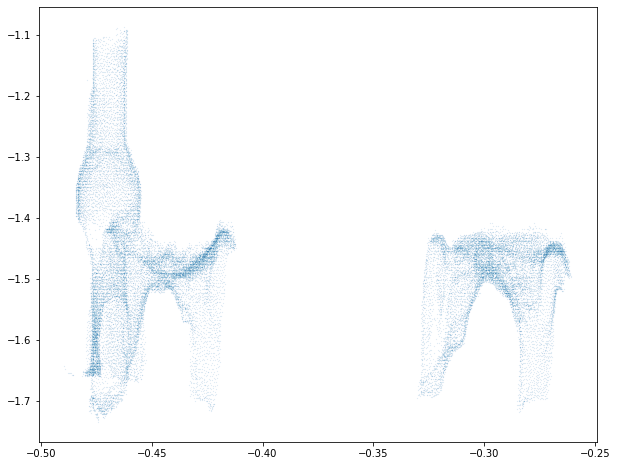

Estimated number of clusters: 3
Estimated number of noise points: 0


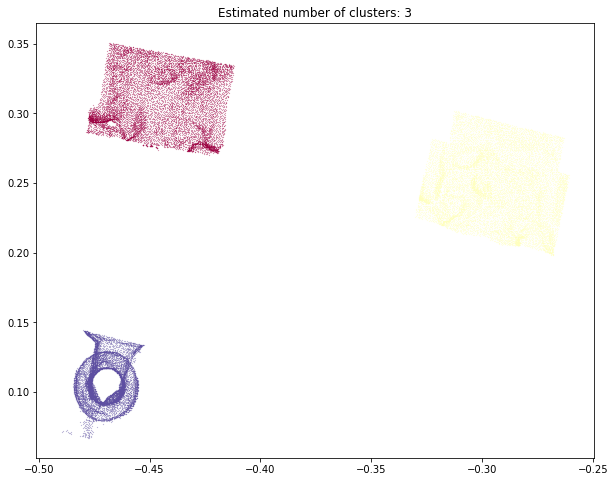

number of outliers 0


save and wait for plot 3D ? y
waiting to continue: 
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 5


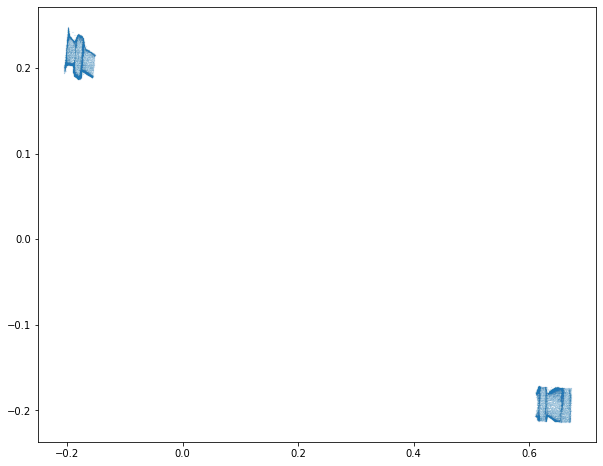

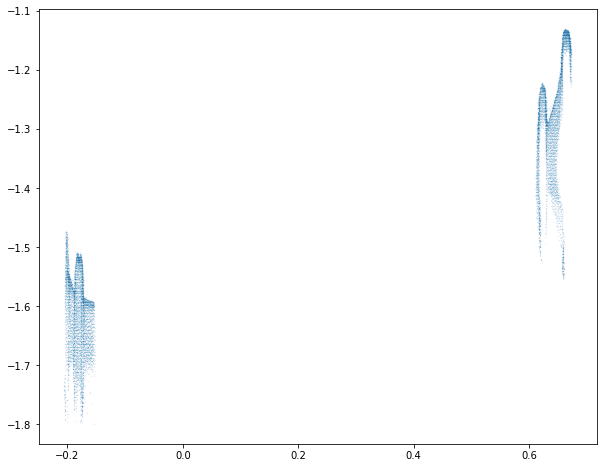

Estimated number of clusters: 2
Estimated number of noise points: 3


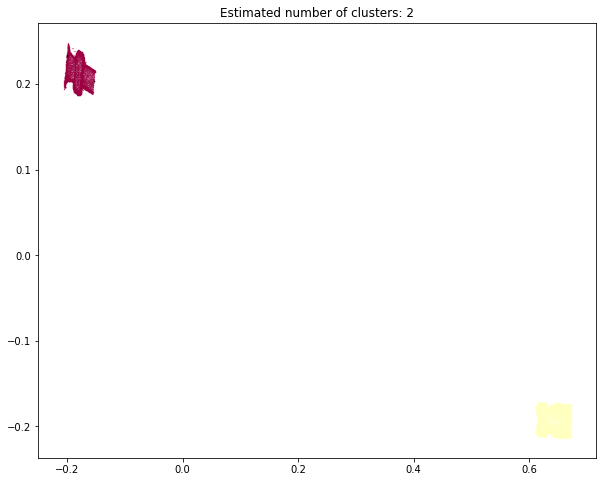

number of outliers 3


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? 0.02
give number of min sampels: 10


Estimated number of clusters: 2
Estimated number of noise points: 1


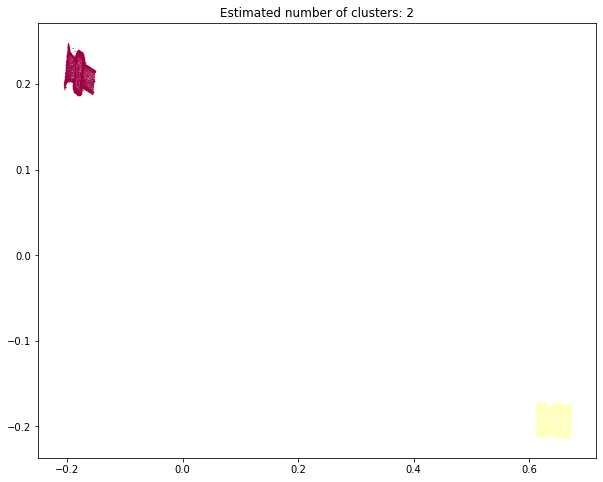

number of outliers 1


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 6


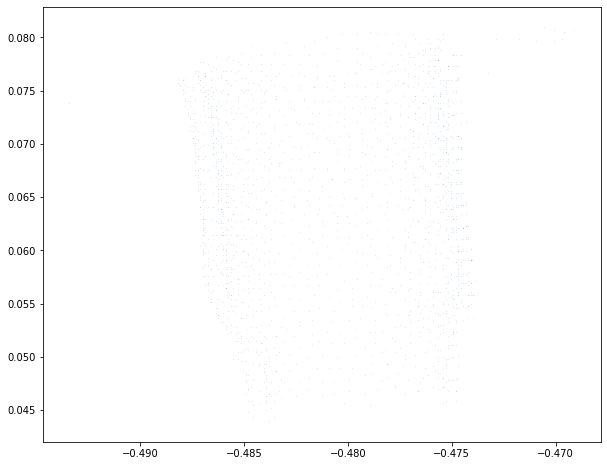

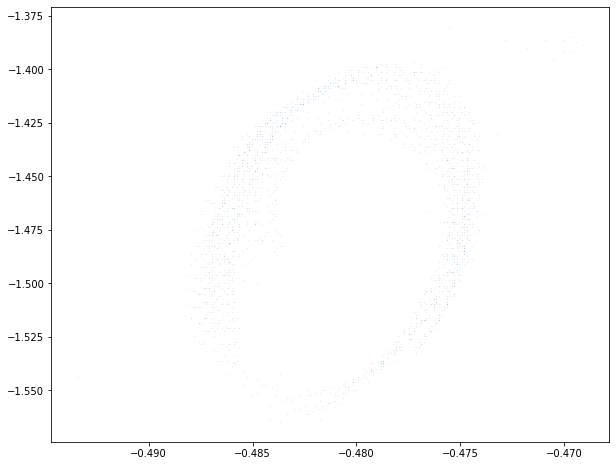

Estimated number of clusters: 1
Estimated number of noise points: 0


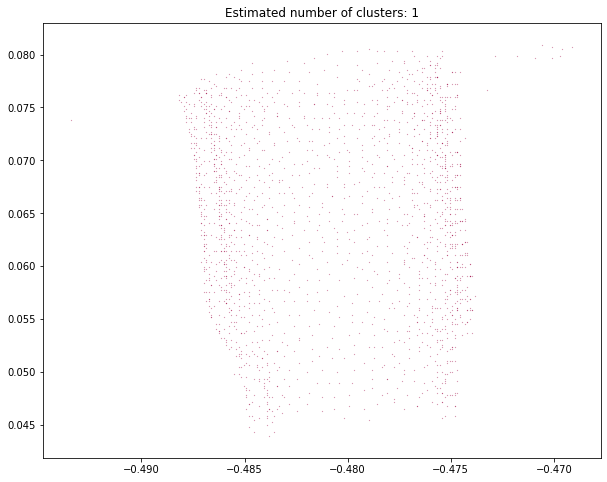

number of outliers 0


save and wait for plot 3D ? y
waiting to continue: 
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 7


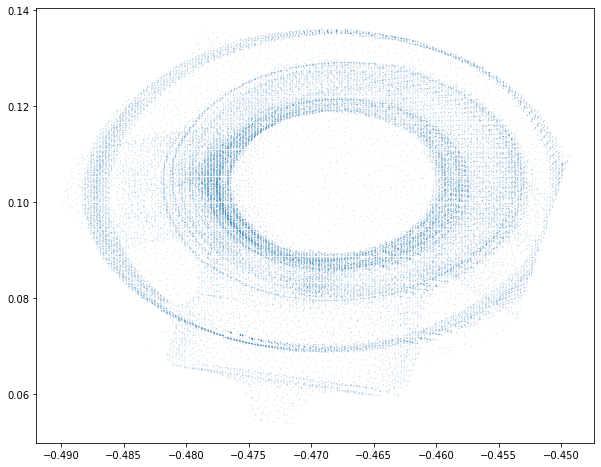

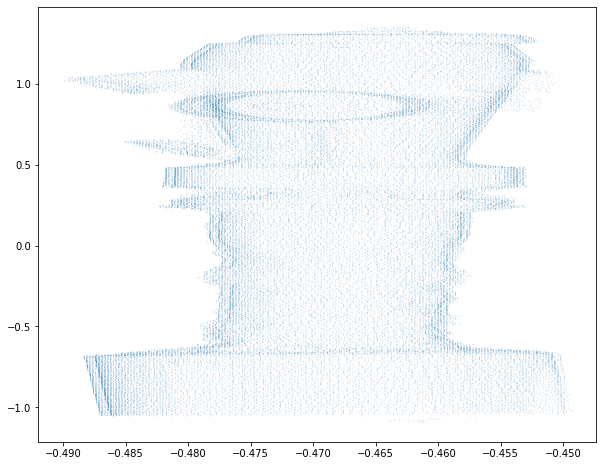

Estimated number of clusters: 1
Estimated number of noise points: 0


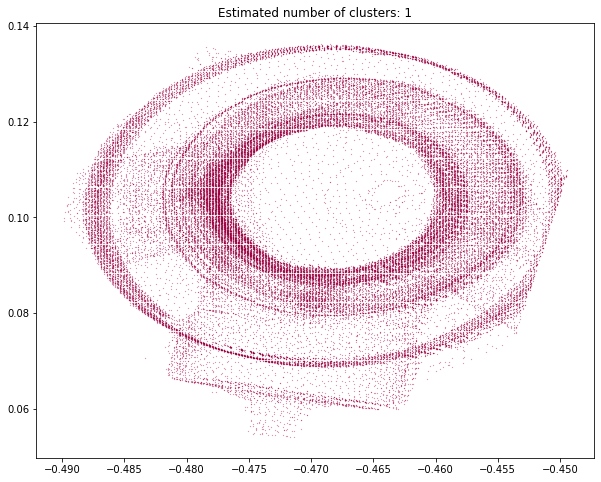

number of outliers 0


save and wait for plot 3D ? n
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 8


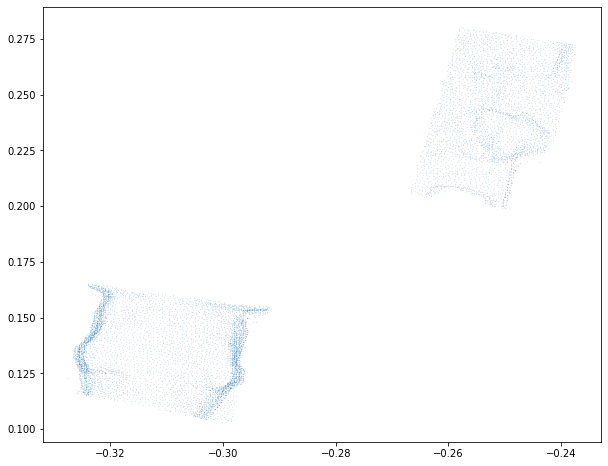

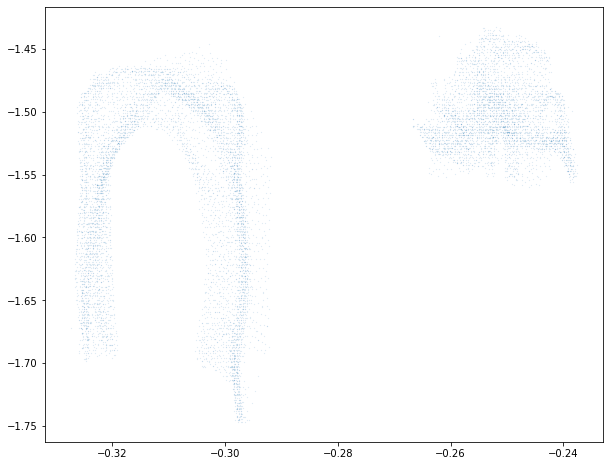

Estimated number of clusters: 2
Estimated number of noise points: 0


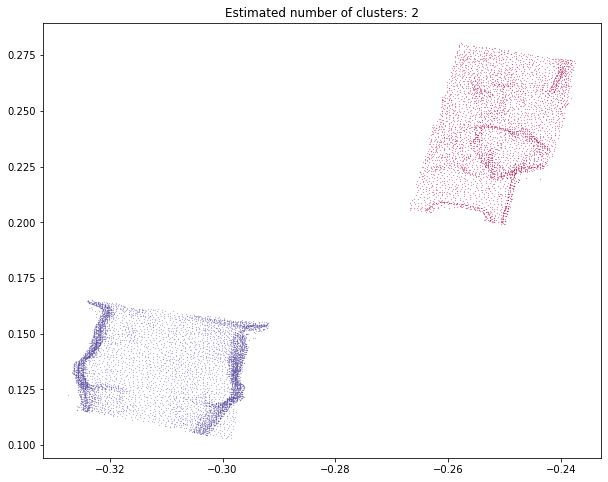

number of outliers 0


save and wait for plot 3D ? y
waiting to continue: 
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


////////////////////////////
 analyzing class: 9


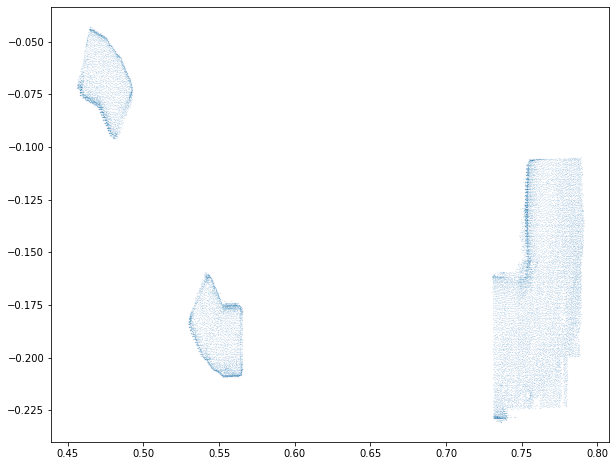

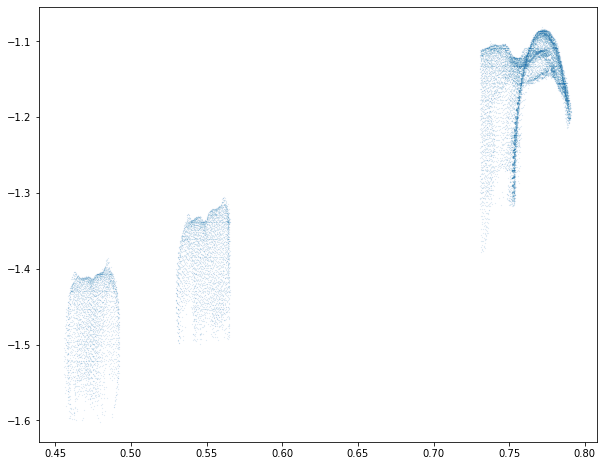

Estimated number of clusters: 3
Estimated number of noise points: 0


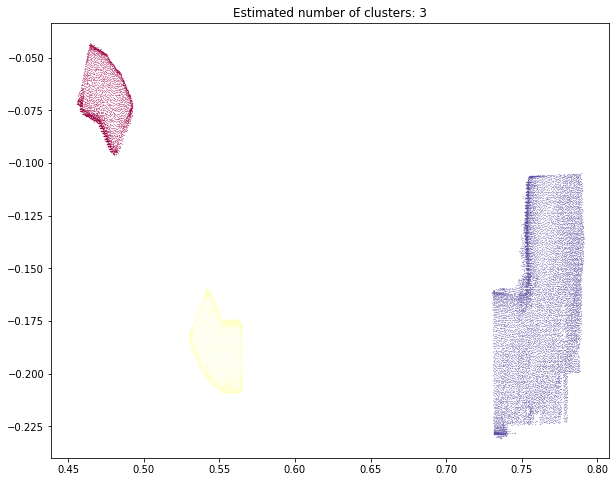

number of outliers 0


save and wait for plot 3D ? y
waiting to continue: 
is the cluster ok (give new epsi value if not) (current epsilon 0.020000)? y


In [108]:
# save the point data in variable final_points
# the columns are x,y,z, r,g,b, class, instance 
final_points = -1*np.ones([len(points),8])
# fill it with the same data as points but keep last column free
final_points[:,0:7] = points

#save corners them in a dictionary of lists s.t the key is class and instance numbers index into the corners for each instance
final_corners = {}


# remove 0 if background
classes = set(lidar_inFile.classification) - set([0])

# the radius of the clustering
my_eps=0.1
my_min_samples=10
for class_num in classes:
    
    print('////////////////////////////\n analyzing class:', class_num)
    # selet class points and standardize
    mask = lidar_inFile.classification == class_num
    class1 = points[mask]
    class1 = class1[:,0:3]
    
    
    # plot 2D x-y
    plt.figure(figsize=(10, 8)) 
    plt.scatter(class1[:,0], class1[:,1], marker='.', s=0.01)
    plt.show()
    
    # plot x-z
    plt.figure(figsize=(10, 8)) 
    plt.scatter(class1[:,0], class1[:,2], marker='.', s=0.01)
    plt.show()
    
    
    
    # do the clustering
    is_cluter_ok = False
    while not is_cluter_ok:
        # Compute DBSCAN
        db = DBSCAN(eps=my_eps, min_samples=my_min_samples).fit(class1)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        # determin core sampels
        core_samples_mask[db.core_sample_indices_] = True
        
        # given class label by the algo
        labels = db.labels_
        
        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)


        # plot clustering result
        # Black removed and is used for noise instead.
        plt.figure(figsize=(10, 8))

        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xyz = class1[class_member_mask & core_samples_mask]
            plt.scatter(xyz[:, 0], xyz[:, 1], marker='.', color=tuple(col),
                      s=0.1)

            xyz = class1[class_member_mask & ~core_samples_mask]
            plt.scatter(xyz[:, 0], xyz[:, 1], marker='.', color=tuple(col),
                      s=1)

        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()

        print('number of outliers %d'%len(labels[labels==-1]))
        
        # ask wethear to save to file and wait to plot
        ans = input('save and wait for plot 3D ?')
        if ans=='y':
            # save to file then use vscode to run the interactive plot
            np.savez('point_cloud',xyz=class1, labels=labels)
            # wait
            input('waiting to continue:')
        
        # ask if the clustering is ok
        ans = input('is the cluster ok (give new epsi value if not) (current epsilon %f)?'%my_eps)
        if ans =='y':
            is_cluter_ok = True
        else:
            my_eps = float(ans)
            my_min_samples = int(input('give number of min sampels:'))
            
    
    
    
    # remove the points labeled -1 (-1 are outliers)
    obj_labels = list(unique_labels - set([-1]))
    obj_labels
    
    # get the bboxes
    # one row per pipe each one has 8 corners for bbox
    corners = np.zeros((len(obj_labels), 8, 3))

    for obj_idx in obj_labels:
        # filter down to 1 instance
        object_member_mask = (labels == obj_idx)
        xyz = class1[object_member_mask]
        # find the bbox of points in xyz
        # using PCA
        corners[obj_idx] = find_bboxes(xyz)
    
        
    # save the results for this class
    ##########################
    # set instance
    final_points[mask, 7] = labels
    
    ##################################
    # save the bboxes
    # the class number is the key for dictionary
    final_corners[str(class_num)] = corners
    
    
    
        
    # sanity checks
    
    if not is_box(corners):
        print('box orthogonality failed')
        print(class_num)
        break
    
    
    if not all_points_in_box(class1, corners, labels, obj_labels):
        print('points inside box failed')
        print(class_num)
        break

# **Important:**

we have two types of unimportant points:
1. the points without a class that have class 0 and instance -1
2. points with a class but detected as noise in the clustering so they have some non zero class number but a -1 instance\

note: 
* the points are saved in the column format: x,y,z, r,g,b, class, instance
* the corners are saved in dictionary format {'class_number': an N x 8 x 3 numpy array of corners}. N is the number of instances in this class and the index corresponds to the same instance number in the points file. 

In [110]:
# save the data for the current analyzed scene

# save points
np.save('cleaned_tram_points', final_points)

# save corners
import pickle
with open('tram_bboxes.p', 'wb') as f:
    pickle.dump(final_corners, f, protocol=pickle.HIGHEST_PROTOCOL)